In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models

2024-04-29 14:17:11.540076: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 14:17:12.557365: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-29 14:17:12.557499: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-29 14:17:12.557515: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
tf.config.list_physical_devices()

2024-04-29 14:17:13.679382: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-29 14:17:13.679424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hires-lambda1.cs.unc.edu
2024-04-29 14:17:13.679435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hires-lambda1.cs.unc.edu
2024-04-29 14:17:13.679520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.104.12
2024-04-29 14:17:13.679556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.104.12
2024-04-29 14:17:13.679566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.104.12


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
from xgboost import XGBClassifier
from scipy.linalg import null_space
from sklearn.cross_decomposition import CCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
import pickle
import json

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [7]:
with open('./chem/train.csv', 'r') as f:
  dataX = np.float32(np.array([line.strip().split(',')[2:] for line in f])[1:])

with open('./chem/train.csv', 'r') as f:
  dataY = np.float32(np.array([line.strip().split(',')[1] for line in f])[1:])

X = dataX
Y = dataY

In [22]:
with open('./chem/val_ood.csv', 'r') as f:
  external_X = np.float32(np.array([line.strip().split(',')[4:] for line in f])[1:])

with open('./chem/val_ood.csv', 'r') as f:
  external_Y = np.float32(np.array([line.strip().split(',')[1] for line in f])[1:])


In [9]:
# standardize the data
mu_x = np.mean(X, 0, keepdims=True)
# sigma_x = np.std(X, 0, keepdims=True)
sigma_x = np.ones_like(mu_x)
X = (X-mu_x)/sigma_x

In [10]:
print(X.shape)
print(Y.shape)

(5997, 1024)
(5997,)


In [11]:
class RandFeats:
  # def __init__(self, sigma_rot, d, D=196):
  def __init__(self, sigma_rot, d, D=128):

    self.sigmas = [sigma_rot/4, sigma_rot/2, sigma_rot, sigma_rot*2, sigma_rot*4]
    self.D = D
    self.Ws = []
    for sigma in self.sigmas:
      self.Ws.append(np.float32(np.random.randn(d, D)/sigma))
    self.Ws = np.stack(self.Ws, 0)

  def get_features(self, x_in):
    # phis = []
    # TODO: vectorize
    # for W in Ws:
    #   XW = np.matmul(x_in, W)
    #   phis.append(
    #     np.concatenate([np.sin(XW), np.cos(XW)], -1))
    # return np.concatenate(phis, -1)
    phis = tf.matmul(x_in, self.Ws)  # k x N x D
    phis = tf.transpose(phis, [1, 2, 0])  # N x D x k
    phis = tf.concat((tf.sin(phis), tf.cos(phis)), 1)
    return tf.reshape(phis, [x_in.shape[0], -1])

  def __call__(self, x_in):
    return self.get_features(x_in)

# def define_rand_feats(ndata_feats, nrand_feats=1000, gamma=1.0):
def define_rand_feats(X, xD):
  """
  Args:
    ndata_feats: scalar value of total number of data features
    nrand_feats: scalar value of total number of desired random features
    gamma: Float, scale of frequencies

  Returns:
    Ws: ndata_feats x nrand_feats weight matrix
    bs: 1 x nrand_feats bias vector
  """
  tf.random.set_seed(123129) # For reproducibility
  from scipy.spatial import distance
  rprm = np.random.permutation(X.shape[0])
  ds = distance.cdist(X[rprm[:100], :], X[rprm[100:], :])
  sigma_rot = np.mean(np.sort(ds)[:, 5])
  model = RandFeats(sigma_rot, X.shape[1], int(X.shape[1]*xD))

  # Ws = gamma*tf.random.normal((ndata_feats, nrand_feats))
  # bs = 2.0*np.pi*tf.random.uniform((1,nrand_feats))
  # return Ws, bs
  return model

In [12]:
Dx = [1.5, 2, 4, 8, 10, 16]

In [13]:
def get_rand_feats(X, model):
  """
  Args:
    X: N x d matrix of input features
    Ws: ndata_feats x nrand_feats weight matrix
    bs: 1 x nrand_feats bias vector

  Returns:
    Phis: N x D matrix of random features
  """
  # XWs = tf.matmul(X, Ws)
  # return tf.cos(XWs+bs)
  return model(X)

In [14]:
def linear_coefs(X, Y):
  """
  Args:
    X: N x d matrix of input features
    Y: N x 1 matrix (column vector) of output response

  Returns:
    Beta: d x 1 matrix of linear coefficients
  """
  clf = LogisticRegression(random_state=0, solver='liblinear').fit(X, Y)
  print(clf.score(X, Y))
  wgts = np.hstack((clf.intercept_[:,None], clf.coef_))
  prd = (1 / (1 + np.exp(-np.concatenate([np.ones((X.shape[0], 1)), X], axis=-1) @ wgts.T)) > 0.5) *1.0
  # print((prd[:, 0]==Y).mean())
  return wgts
  # beta = tf.linalg.solve(tf.matmul(tf.transpose(X),X), tf.matmul(tf.transpose(X), Y[:, None]))
  # return beta

In [15]:
def project_and_filter(X, dir, percentile=75):
  projs = np.dot(X, dir)
  thresh = np.percentile(projs, 100 - percentile)
  filtered_idxs = projs >= thresh
  return X[filtered_idxs], filtered_idxs

In [16]:
def get_models(X, Y, pca_projs, dirs, model, percentile=75):
  #X_subsets = []
  #data_ids = []
  #Y_subsets = []
  betas = []
  i = 0
  for dir in dirs: # TODO: Vectorize
    if i % 25 == 0: print(f"Step {i}")
    X_sub, X_ids = project_and_filter(X, dir, percentile)
    Y_sub = Y[X_ids]
    # print((X_sub@pca_projs).shape)
    est = XGBClassifier(n_estimators=40)
    est.fit(get_rand_feats(X_sub@pca_projs, model), Y_sub)
    print(est.score(get_rand_feats(X_sub@pca_projs, model), Y_sub))
    # beta = linear_coefs(get_rand_feats(X_sub@pca_projs, model), Y_sub)

    #X_subsets.append(X_sub)
    #data_ids.append(X_ids)
    #Y_subsets.append(Y_sub)
    betas.append(est)
    i += 1
    if i == len(dirs) - 1: print(f"Done")

  # cant do this because subsets of variable sizes
  #X_subsets = np.array(X_subsets)
  #data_ids = np.array(data_ids)
  #Y_subsets = np.array(Y_subsets)
  # betas = np.array(betas)

  return betas
  #return X_subsets, data_ids, Y_subsets, betas

In [17]:
X.shape

(5997, 1024)

In [18]:
s, u, v = tf.linalg.svd(X)

2024-04-29 14:17:18.700898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
dims = [0.05, 0.1, 0.2, 0.4, 0.8]
pca_projs = v[:, :int(X.shape[-1]*dims[2])]

In [20]:
X.shape, pca_projs.shape

((5997, 1024), TensorShape([1024, 204]))

In [21]:
np.random.seed(74)
X_prjs = np.array(X@pca_projs)
model = define_rand_feats(X_prjs, 2)

N = 2**9    # ~ 8k
# N = 2**2    # ~ 8k
d = X.shape[-1]
random_dirs = np.random.randn(N, d) # Maybe do the random directions in the random feature space??? Feel like that makes more sense

random_dirs = random_dirs / np.linalg.norm(random_dirs, axis=1, keepdims=True)

#X_subsets, data_ids, Y_subsets, betas = get_models(X, Y, random_dirs, Ws, bs, percentile=33)
betas = get_models(X, Y, pca_projs, random_dirs, model, percentile=40)

Step 0
0.9954147561483951
0.9958333333333333
0.995
0.995831596498541
0.995831596498541
0.9949979157982493
0.995831596498541
0.9945810754481034
0.9933305543976657
0.9924968736973739
0.9924968736973739
0.9949979157982493
0.9954147561483951
0.9949979157982493
0.9949979157982493
0.9941642350979575
0.9924968736973739
0.9949979157982493
0.992080033347228
0.995831596498541
0.9949979157982493
0.9975
0.992080033347228
0.9937473947478116
0.9945810754481034
Step 25
0.9966652771988328
0.9937473947478116
0.995831596498541
0.9941642350979575
0.9966652771988328
0.995831596498541
0.9954147561483951
0.9962484368486869
0.9908295122967903
0.995831596498541
0.9949979157982493
0.9962484368486869
0.9933305543976657
0.9970821175489787
0.995831596498541
0.9962484368486869
0.9949979157982493
0.995831596498541
0.9954147561483951
0.9945810754481034
0.9941642350979575
0.9945810754481034
0.995831596498541
0.9949979157982493
0.9941642350979575
Step 50
0.9958333333333333
0.9949979157982493
0.9941642350979575
0.99416

In [ ]:
np.save('random_dirs.npy', random_dirs)
np.save('betas.npy', betas)
np.save('Ws.npy', model.Ws)


In [ ]:
random_dirs = tf.constant(np.load('/content/drive/My Drive/ml-ood/random-dirs-chem-2048.npy'))
betas = tf.squeeze(tf.constant(np.load('/content/drive/My Drive/ml-ood/betas-chem-2048.npy')))
model = define_rand_feats(X)
model.Ws = tf.constant(np.load('/content/drive/My Drive/ml-ood/Ws-chem-2048.npy'))

In [40]:
betas = tf.squeeze(betas)
print(betas.shape)
random_dirs = tf.constant(random_dirs)
print(random_dirs.shape)

ValueError: Attempt to convert a value (DecisionTreeClassifier(max_features='auto', random_state=723094850)) with an unsupported type (<class 'sklearn.tree._classes.DecisionTreeClassifier'>) to a Tensor.

In [24]:
var = tf.math.reduce_variance(betas, axis=0)
mean_var = tf.reduce_mean(var)
print(mean_var)

ValueError: Attempt to convert a value (DecisionTreeClassifier(max_features='auto', random_state=1930866436)) with an unsupported type (<class 'sklearn.tree._classes.DecisionTreeClassifier'>) to a Tensor.

In [51]:
sample = 3
def softmax(X, wgts):
  sd = (1 / (1 + np.exp(-np.concatenate([np.ones((X.shape[0], 1)), X], axis=-1) @ wgts.numpy().T)) > 0.5) *1.0
  return sd[:]

X_sub, X_ids = project_and_filter(X, random_dirs[sample], 35)
Y_sub = Y[X_ids]

prd = betas[sample].predict(get_rand_feats(tf.cast(X_sub@pca_projs, dtype=tf.float32), model))
# prd = softmax(get_rand_feats(X_sub@pca_projs, model), betas[sample])

(prd == Y_sub).mean()

0.9957122439256789

In [52]:
ex_X = tf.cast(external_X, tf.float32)
ex_Y = external_Y
ex_X = (ex_X-mu_x)/sigma_x

X_sub, X_ids = project_and_filter(ex_X, random_dirs[sample], 35)
Y_sub = ex_Y[X_ids]

prd = betas[sample].predict(get_rand_feats(tf.cast(X_sub@pca_projs, dtype=tf.float32), model))
# prd = softmax(get_rand_feats(X_sub@pca_projs, model), betas[sample])

(prd == Y_sub).mean()

0.5762195121951219

## Should test Betas performance first

In [ ]:
from tensorflow.keras import layers, models

beta_dim = betas.shape[-1]
input_dir_dim = random_dirs.shape[-1]
latent_dim = 64

# Encoder
beta_input = layers.Input(shape=(beta_dim,))
dir_input = layers.Input(shape=(input_dir_dim,))
encoder_inputs = layers.Concatenate()([beta_input, dir_input])
x = layers.Dense(512, activation=tf.nn.elu)(encoder_inputs)
x = layers.Dense(256, activation=tf.nn.elu)(x)
x = layers.Dense(128, activation=tf.nn.elu)(x)
x = layers.Dense(64, activation=tf.nn.elu)(x)
x = layers.Dense(64, activation=tf.nn.elu)(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

def sampling(args):
  z_mean, z_log_var = args
  eps = tf.random.normal(shape=tf.shape(z_mean))
  return z_mean + tf.exp(0.5 * z_log_var) * eps

z = layers.Lambda(sampling)([z_mean, z_log_var])


### Using direction in Decoder is weird
### Likely just train VAE solely on betas with directions


# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
decoder_dir_input = layers.Input(shape=(input_dir_dim,))
decoder_inputs = layers.Concatenate()([latent_inputs, decoder_dir_input])
x = layers.Dense(64, activation=tf.nn.elu)(decoder_inputs)
x = layers.Dense(64, activation=tf.nn.elu)(decoder_inputs)
x = layers.Dense(128, activation=tf.nn.elu)(decoder_inputs)
x = layers.Dense(256, activation=tf.nn.elu)(decoder_inputs)
x = layers.Dense(512, activation=tf.nn.elu)(x)
beta_output = layers.Dense(beta_dim)(x)

# Instantiate model
encoder = models.Model([beta_input, dir_input], [z_mean, z_log_var, z], name="encoder")
decoder = models.Model([latent_inputs, decoder_dir_input], beta_output, name="decoder")

# VAE
outputs = decoder([encoder([beta_input, dir_input])[2], dir_input])
vae = models.Model([beta_input, dir_input], outputs, name="vae")
vae.encoder = encoder
vae.decoder = decoder

In [ ]:
def vae_loss(inputs, outputs, z_mean, z_log_var, reg=1.0):
  # recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(inputs - outputs), axis=-1))
  recon_loss = tf.reduce_mean(1-tf.reduce_sum(tf.linalg.normalize(tf.cast(inputs, dtype=tf.float32), axis=-1)[0] *
                                              tf.linalg.normalize(outputs, axis=-1)[0], axis=-1))
  kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))
  total_loss = recon_loss + 0.001 * kl_loss
  return total_loss, recon_loss, kl_loss

In [ ]:
opt = tf.keras.optimizers.Adam()

def train_step(model, inputs, dir_inputs):
  with tf.GradientTape() as tape:
    z_mean, z_log_var, z = model.encoder([inputs, dir_inputs])
    outputs = model.decoder([z, dir_inputs])
    total_loss, recon_loss, kl_loss = vae_loss(inputs, outputs, z_mean, z_log_var)
  grads = tape.gradient(total_loss, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))
  return total_loss, recon_loss, kl_loss

In [ ]:
def batch(betas, dirs, batch_size):
  num_samples = betas.shape[0]
  indices = np.arange(num_samples)
  np.random.shuffle(indices)
  betas = np.array(betas)[indices]
  dirs = np.array(dirs)[indices]
  for i in range(0, betas.shape[0], batch_size):
    yield tf.constant(betas[i:i+batch_size]), tf.constant(dirs[i:i+batch_size])

In [ ]:
epochs = 2000
batch_size = 32

for i in range(epochs):
  print(f"Epoch {i}")
  for step, (batch_betas, batch_dirs) in enumerate(batch(betas, random_dirs, batch_size)):
    loss_vals = train_step(vae, batch_betas, batch_dirs)
    if step % 100 == 0: # tmp
      print(f"Step {step}: loss = {loss_vals[0].numpy()}, recon_loss = {loss_vals[1].numpy()}, kl_loss = {loss_vals[2].numpy()}")
  print()

Epoch 0
Step 0: loss = 1.0113502740859985, recon_loss = 1.0057954788208008, kl_loss = 5.554746627807617


KeyboardInterrupt: 

In [ ]:
vae.save_weights('./my_checkpoint/chekpont')

In [ ]:
vae.load_weights('./my_checkpoint/chekpont')

In [ ]:
# !zip -r my_checkpoint.zip my_checkpoint/
!unzip chem-checkpoint.zip

Archive:  chem-checkpoint.zip
   creating: my_checkpoint/
  inflating: my_checkpoint/chekpont.index  
  inflating: my_checkpoint/.data-00000-of-00001  
  inflating: my_checkpoint/checkpoint  
  inflating: my_checkpoint/chekpont.data-00000-of-00001  
  inflating: my_checkpoint/.index    


In [ ]:
random_dirs = np.random.randn(50_000, d)

In [ ]:
# Dont really think this works, since the latent space should be conditioned on the direction
# Just to try something
# Likely better to just have VAE solely on betas w/o directions

def generate_new_betas(model, num_samples=1):
  random_dirs1 = np.random.randn(num_samples, d)
  random_dirs2 = np.random.randn(num_samples, d)
  random_dirs1 = random_dirs1 / np.linalg.norm(random_dirs1, axis=1, keepdims=True)
  random_dirs1 = tf.constant(random_dirs1)
  random_dirs2 = random_dirs2 / np.linalg.norm(random_dirs2, axis=1, keepdims=True)
  random_dirs2 = tf.constant(random_dirs2)
  latent_samples1 = tf.random.normal(shape=(num_samples, latent_dim))
  latent_samples2 = tf.random.normal(shape=(num_samples, latent_dim))
  # latent_samples = tf.ones_like(tf.random.normal(shape=(num_samples, latent_dim)))
  return model.decoder([latent_samples1, random_dirs1]), random_dirs1, model.decoder([latent_samples2, random_dirs1])

In [ ]:
drawn_betas1, dir1, drawn_betas2 = generate_new_betas(vae, 50_000)

In [ ]:
tf.keras.losses.CosineSimilarity(axis=-1)(drawn_betas1, drawn_betas2)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.99951625>

In [ ]:
drawn_betas1[0:3]

<tf.Tensor: shape=(3, 1793), dtype=float32, numpy=
array([[  1.1108708 ,  -1.0370612 ,   1.0474906 , ...,  -8.708343  ,
         -2.0336905 ,   0.90315366],
       [  0.59400725,  -4.0057716 ,  -8.4961195 , ..., -12.938477  ,
         20.990461  ,  -5.11088   ],
       [  1.6494957 ,  -0.9708191 , -10.286863  , ...,  15.719532  ,
         -2.167779  ,   1.6435473 ]], dtype=float32)>

In [ ]:
var = tf.math.reduce_variance(drawn_betas1, axis=0)
mean_var = tf.reduce_mean(var)
print(mean_var)

tf.Tensor(53.601833, shape=(), dtype=float32)


In [ ]:
np.mean(drawn_betas1 @ tf.transpose(drawn_betas))

In [ ]:
ood_val_features = convert_data_to_features(ood_val_data)
#ood_test_features = convert_data_to_features(ood_test_data)

ood_val_labels = np.array([entry['cls_label'] for entry in ood_val_data])
#ood_test_labels = np.array([entry['cls_label'] for entry in ood_test_data])

NameError: name 'convert_data_to_features' is not defined

In [ ]:
external_X = tf.cast(ood_val_features, tf.float32)
external_Y = ood_val_labels

In [23]:
external_X = (external_X-mu_x)/sigma_x
external_randfeats_X = get_rand_feats(external_X@pca_projs, model)
randfeats_X = get_rand_feats(X@pca_projs, model)

In [ ]:
print(external_X[0])
print(external_randfeats_X[0][:10])
print(external_Y[0])

[ 1.9594797  -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
 -0.03134901]
tf.Tensor(
[ 0.63068485 -0.77454156  0.8053942  -0.99999964  0.8786271  -0.42361107
  0.90560085  0.49423513  0.85399747  0.79033244], shape=(10,), dtype=float32)
0.0


In [ ]:
print(external_X.shape)
print(external_randfeats_X.shape)
print(external_Y.shape)

(937, 1024)
(937, 1792)
(937,)


In [ ]:
print(external_X[:10])
print(external_Y[:10])

[[ 1.9594797  -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]
 [-0.04052026 -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]
 [-0.04052026 -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]
 ...
 [-0.04052026 -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]
 [-0.04052026 -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]
 [-0.04052026 -0.29764882 -0.08170752 ... -0.04052026 -0.06053026
  -0.03134901]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [27]:
def get_preds(randfeats, betas):
  """
  Args:
    randfeats: N x d
    betas: M x d
  Return:
    preds: N x M - each beta predicts on each instance
  """
  #preds = []
  #for i in range(len(betas)):
  #  if i % 25_000 == 0: print(f"{i} Predictions Made")
  #  preds.append(np.matmul(randfeats, betas[i]))
  #return np.array(preds)
  # sd = (1 / (1 + np.exp(-np.concatenate([np.ones((randfeats.shape[0], 1)), randfeats], axis=-1) @ betas.numpy().T)))
  return np.concatenate([_b.predict_proba(randfeats)[:, 1][None, :] for _b in betas], axis=0).T
  # return betas[sample].predict_proba(get_rand_feats(tf.cast(X_sub@pca_projs, dtype=tf.float32), model))

  # betaT = np.transpose(betas) # d x M
  # preds = np.matmul(randfeats, betaT) # N x M
  # return preds

def aggregate_preds(preds):
  mean_pred = np.mean(preds, axis=-1, keepdims=False)
  # mean_pred = np.sum(preds, axis=-1, keepdims=False)
  std_pred = np.std(preds, axis=-1, keepdims=False)
  # Typically 0.5 threshold, just was all 0s
  return np.float32(mean_pred > 0.5), np.float32(mean_pred), np.float32(std_pred)

def get_preds_and_aggregate(randfeats, betas):
  preds = get_preds(randfeats, betas)
  return *aggregate_preds(preds), preds

def get_preds_and_aggregate_sorted(randfeats, eX, dirs, betas):
  preds = get_preds(randfeats, betas)
  projs = np.dot(tf.linalg.normalize(eX, axis=-1)[0], tf.transpose(tf.linalg.normalize(dirs, axis=-1)[0]))
  print(projs.shape, preds.shape)
  thresh = np.percentile(projs, 100 - 40, axis=-1)
  # wghts = (projs > thresh[:, None]) * projs
  wghts = tf.ones_like(projs > thresh[:, None])
  # wghts = (projs > thresh[:, None]).astype(np.float64)
  wghts /= np.sum(wghts, axis=-1, keepdims=True)
  return aggregate_preds(preds * wghts)


# ext_probs, mp_rand, sp_rand = get_preds_and_aggregate(external_randfeats_X, external_X, random_dirs, betas) # 0.622
# ext_preds, mp_rand, sp_rand = get_preds_and_aggregate(external_randfeats_X, drawn_betas1) # 0.622
# ext_preds, mp_rand, sp_rand = get_preds_and_aggregate(external_randfeats_X, betas) # 0.634
# ext_preds, mp_rand, sp_rand = get_preds_and_aggregate(randfeats_X, drawn_betas) # 0.85
ext_preds, mp_rand, sp_rand, pred = get_preds_and_aggregate(external_randfeats_X, betas) # 0.91

In [ ]:
np.dot(tf.linalg.normalize(tf.ones((100, 200)), axis=-1)[0], tf.transpose(tf.linalg.normalize(tf.ones((100, 200)), axis=-1)[0])).shape

(100, 100)

In [ ]:
drawn_betas[0].numpy(), betas[0].numpy()

(array([ 1.767455  ,  0.1001012 , -0.54182774, ..., -6.8707843 ,
         7.257238  , -0.5050444 ], dtype=float32),
 array([-0.0186294 ,  0.06830448, -0.27256313, ..., -0.72351612,
         0.81710885,  0.05805234]))

In [ ]:
print(ext_preds.shape)

(937,)


In [44]:
print(ext_preds)

NameError: name 'ext_preds' is not defined

In [28]:
# testing_Y = Y
# ext_preds = ext_probs > 0.5
testing_Y = external_Y

print("First 10 Predictions: ", ext_preds[:10])
print("Total Positive Preds: ", sum(ext_preds))
print("Total Preds: ", len(ext_preds))
print("% Positive Preds: ", sum(ext_preds) / len(ext_preds))
print()
print("First 10 Ground Truth: ", testing_Y[:10])
print("Total Positive Ground Truth: ", sum(testing_Y))
print("Total Ground Truth: ", len(testing_Y))
print("% Positive Ground Truth: ", sum(testing_Y) / len(testing_Y))
print()
print("Accuracy: ", sum(ext_preds == testing_Y) / len(ext_preds))

First 10 Predictions:  [0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Total Positive Preds:  499.0
Total Preds:  937
% Positive Preds:  0.5325506937033084

First 10 Ground Truth:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total Positive Ground Truth:  421.0
Total Ground Truth:  937
% Positive Ground Truth:  0.44930629669156885

Accuracy:  0.6542155816435432


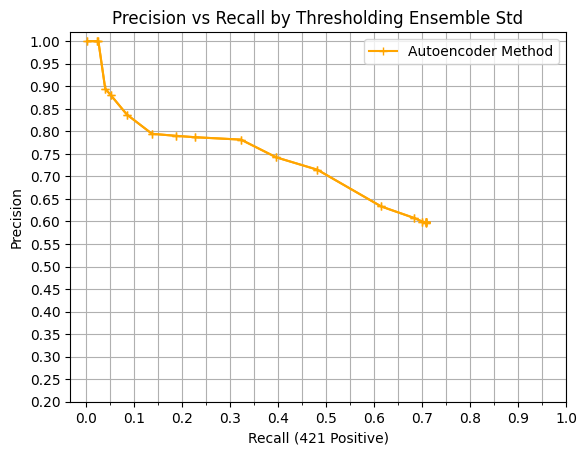

In [29]:
threshs = sp_rand
std_threshs = np.linspace(np.min(threshs), np.max(threshs), 20) # Diff std. dev. thresholds (20 of them in this case)
reject_rate = [1 - np.mean((threshs<=s)) for s in std_threshs] # Portion of instances rejected @ each std threshold
accus = [np.mean((ext_preds==external_Y)[(threshs<=s)]) for s in std_threshs] # Acc @ each std thresh.
tps = [np.sum(((external_Y)*(ext_preds==external_Y))[(threshs<=s)]) for s in std_threshs]  # correct and positive
fps = [np.sum(((ext_preds)*(ext_preds!=external_Y))[(threshs<=s)]) for s in std_threshs]  # incorrect and predicted positive
pos = np.sum(external_Y)
recall = [tp/pos for tp in tps]
precision = [tp/(tp+fp) for tp, fp in zip(tps, fps)]
plt.plot(recall, precision, marker='+', c='orange')

plt.plot(recall, precision, marker='+', c='orange')
plt.xticks(np.arange(0, 1.01, step=0.1))
plt.xticks(np.arange(0, 1.01, step=0.05), minor=True)
plt.yticks(np.arange(.2, 1.01, step=0.05))
plt.grid(True, which='both')
plt.xlabel('Recall ({} Positive)'.format(int(pos)))
plt.ylabel('Precision')
plt.title('Precision vs Recall by Thresholding Ensemble Std')
plt.legend(['Autoencoder Method'])

In [30]:
from sklearn.metrics import precision_recall_curve
p, r, thres = precision_recall_curve(external_Y, ext_probs)

plt.plot(r, p)

NameError: name 'ext_probs' is not defined

In [ ]:
print(accus)

[0.0, 0.5, 0.4738372093023256, 0.4956921309592188, 0.49409681227863045, 0.49305069493050696, 0.4944530357022793, 0.49494787489975944, 0.49523989958793163, 0.49640065362363645, 0.4956647398843931, 0.4954388303411505, 0.4954494914137462, 0.49574293900941463, 0.4954910841800302, 0.4957665065537735, 0.49576926206167116, 0.49581164606376055, 0.4957713263397577, 0.49579251189072726]
